# <font color="green">Time Series Forecasting using Long Short-Term Memory (LSTM)<font/>

***

Long short-term memory (LSTM) is a special type of recurrent neural network that is optimally suited for sequential data. This model takes advantage of time series autocorrelation and is able to remember patterns in the data over the length of the series. This method was first introduced by [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf). 
    
This notebook builds an LSTM neural network using the [Keras](https://keras.io/) deep learning API to forecast sea surface temperatures in the North Pacific. Specifically the model is built using stateful LSTM and dense layers with a time distributed wrapper.

**Cross Validation** is done using a walk-forward validation, where the model is updated on each time step when new data becomes available. This is also called a rolling window analysis or a rolling forecast where an expanding window is used to train the model. 

<font color=blue>Datasets:</font> The data consists of 5 time series (described below) from the North Pacific at 30n120w, 30n140w, 40n160w, and 50n140w. 

- [NOAA's Optimum Interpolation Sea Surface Temperature](https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html) dataset consists of daily sea surface temperature measurements (ºC) from 1981-09-01 to 2018-06-11. We will be using four time series in the eastern North Pacific.
- [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html) consists of daily atmospheric surface air tempertaure (ºC) at 995 mb from 1948 to present. 
***

<font color=blue>Creator:</font> Hillary Scannell, University of Washington, scanh@uw.edu

<font color=blue>Created:</font> 2018-08-09

***

#### Set Up Python Environment
First we will need to set up our Python environment for deep learning. To do this we will be using Anaconda. If you haven't already, you can download the Windows, OSX, or Linux version of Anaconda [here](https://www.anaconda.com/download/#macos). Make sure you choose Python (>=3.3). After installation, you will want to make sure everything is up-to-date with these commands at the terminal:
```
conda update conda
conda update anaconda
conda install scikit-learn
conda update scikit-learn 
```
To use the Keras API, we also need to install either Theano or TensorFlow backend.
```
conda install theano
conda install -c conda-forge tensorflow
pip install keras
```

Next we will import the Python libraries used in this tutorial. If you have probems importing any of these modules, you may not have them installed on your machine. 

In [1]:
# Import Python Libraries
import numpy as np
import os, time, datetime
from datetime import date
import pandas as pd
from pandas import DataFrame, Series, concat
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras.layers import Dense, LSTM, Activation, Dropout, TimeDistributed
from marineHeatWaves import detect
import seaborn as sns
import time
from numpy import concatenate
import time

Using TensorFlow backend.
/Users/hscannell/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


# <font color="green">1. Import Data<font/>
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [2]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 0 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: '+lat+'ºN,'+lon+'ºS')

Location: 30ºN,120ºS


#### Sea Surface Temperature (degC)

In [3]:
fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp+'sst_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
sst = pd.Series(SST)
print(sst.head())
print(sst_dates[0], sst_dates[-1])

lat ('lat',) 1
lon ('lon',) 1
sst ('time', 'lat', 'lon') 13433
time ('time',) 13433
0    18.559999
1    18.629999
2    18.400000
3    18.359999
4    19.049999
dtype: float32
1981-09-01 2018-06-11


#### Surface Air Temperature (degC)

In [4]:
fp = '/Users/hscannell/Desktop/data/ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/'
data_files = Dataset(fp+'air_sig995_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 

airt = np.squeeze(data_files.variables['air'][:])
airt = airt-273.15


# Time (days since). Do this once because all atmospheric variables have the same time 
f_time = data_files.variables['time'][:]/24 # hours since 1800-01-01 00:00:0.0
ref = datetime.date(1800, 1, 1).toordinal()
airt_time = ref+f_time 

# Dates (yyyy-mm-dd)
airt_dates = [date.fromordinal(tt.astype(int)) for tt in airt_time]
airt_dates = np.array(airt_dates)

print('SST time: {} to {}'.format(sst_dates[0], sst_dates[-1]))
print('SAT time: {} to {}'.format(airt_dates[0], airt_dates[-1]))

# Index into the atmospheric data where it aligns with the SST data
ind0 = int(np.where(airt_time==sst_time[0])[0])
ind00 = int(np.where(airt_time==sst_time[-1])[0])

atmos_dates = airt_dates[ind0:ind00+1]
airt_time = airt_time[ind0:ind00+1]
airt = airt[ind0:ind00+1]
print('ATMOS time: {} to {}'.format(atmos_dates[0], atmos_dates[-1]))

air ('time', 'lat', 'lon') 25049
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 25049
SST time: 1981-09-01 to 2018-06-11
SAT time: 1950-01-01 to 2018-07-31
ATMOS time: 1981-09-01 to 2018-06-11


***
# <font color="green">2. Exploratory Data Analysis<font>
Let's look at how these variables are correlated and what meaningful relationships there might be.

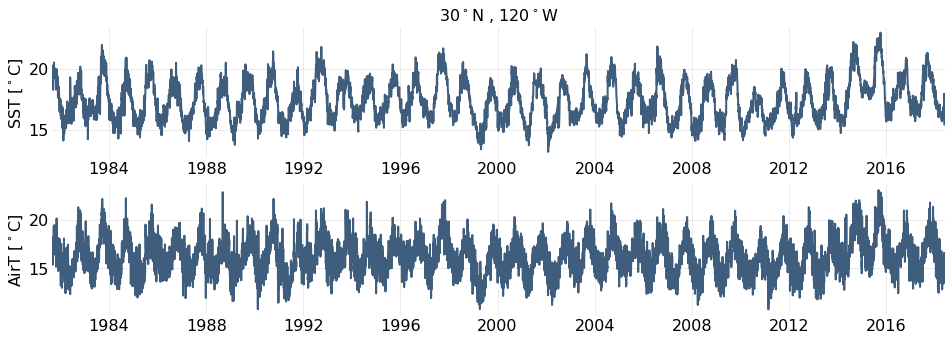

In [6]:
# Plot Time Series
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.figure(figsize=(16, 14))

# SST
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(sst_dates, sst, color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=16)
plt.xlim(sst_dates[0], sst_dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)

# Air Temperature
ax = plt.subplot(512)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmos_dates, airt, color="#3F5D7D", linewidth = 2)
plt.ylabel('AirT [$^\circ$C]', size=16)
plt.xlim(atmos_dates[0], atmos_dates[-1])
plt.grid(True, alpha=0.3)

# # Correlation matrix
# sns.set(style="white")
# corr = data.corr()
# mask = np.zeros_like(corr, dtype=np.bool) # Generate a mask for the upper triangle
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5});

# # Density
# data.plot(kind='density',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False)
# plt.show()

# # Box and Whiskers
# data.plot(kind='box',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False, sharey=False)
# plt.show()

# # Scatter Matrix 
# pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(12, 12), diagonal='kde')
# plt.show()

-0.012104820222135226


Text(0.5,1,'30$^\\circ$N , 120$^\\circ$W')

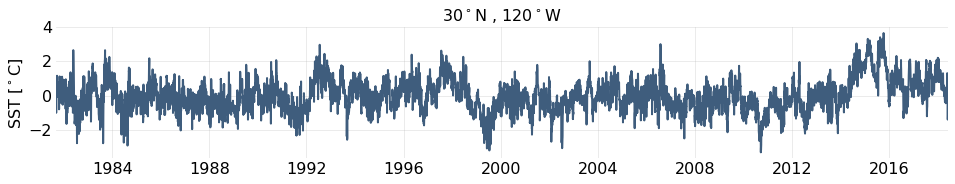

In [13]:
mhw, clim = detect(sst_time, SST, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=5, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)

sst_clim = clim['seas'] 
sst_anom = SST - sst_clim
print(np.mean(sst_anom))

# Plot Time Series
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.figure(figsize=(16, 14))

# SST Anomalies
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(sst_dates, sst_anom, color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=16)
plt.xlim(sst_dates[0], sst_dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)


***
# <font color="green">3. Data Prep<font/>

#### Missing Values
Let's loook at our data structure and check for missing values

***
#### Define the data frame

In [23]:
data = DataFrame(np.transpose(np.array([sst])), columns=['SST'])
#data = DataFrame(np.transpose(np.array([sst, airt])), columns=['SST','AirT'])
print(data.head())

         SST
0  18.559999
1  18.629999
2  18.400000
3  18.359999
4  19.049999


In [24]:
print('Data: ', data.shape)
print (data.head())
print('')

# search for missing values
values = data.values
values = values.astype('float32')
null_data = data[data.isnull().any(axis=1)]
print('Missing values: ', null_data.shape)
print(null_data)
print('')

missing = np.any(np.isnan(values))
finite = np.all(np.isfinite(values)) # determines whether the passed value is a finite number. 
print('Are there missing values in my data?..', missing)
print('Are my values finite?..', finite)

Data:  (13433, 1)
         SST
0  18.559999
1  18.629999
2  18.400000
3  18.359999
4  19.049999

Missing values:  (0, 1)
Empty DataFrame
Columns: [SST]
Index: []

Are there missing values in my data?.. False
Are my values finite?.. True


***
#### Impute with linear interpolation

To fill missing values we will linearly interpolate using the pandas series ```interpolate(method='linear', axis=0, limit=5)```. We set the maximum number of consecutive NaNs to fill equal to 5. 

Let's update the data with the interpolated values and create an array for time that coincides with it. We will create a ```time``` array with days since 0000-01-01 00:00:00 and a ```dates``` array for oridnal time.


<font color="red">*If there are no missing values, this code will do nothing* :)<font/>

In [16]:
# linearly interpolate missing values column wise
interpval = data.interpolate(method='linear', axis=0, limit=5) 

null_data_ind = null_data.index.tolist()
print('Interpolated Values:')
print(interpval.iloc[null_data_ind])

# Update data with interpolated values
data = interpval

dates = atmos_dates
print(dates.shape)

Interpolated Values:
Empty DataFrame
Columns: [SST_ANOM]
Index: []
(13433,)


***
# <font color="green">4. Build a Forecast Model<font/>

1. Create lagged supervised series 
2. Split training, validation, and test data for walk-forward validation
3. Scale training data
4. Design/build network
5. Fit model
6. Evaluate model prediction sequence


<font color="red">**Some notes on the model architecture:**</font>
    
- **Stateful LSTM** uses the last state for each sample at index i in a batch as the initial state for the sample of index i in the following batch. 
- **TimeDistributed** is a "layer wrapper" that allows us to apply a layer to every temporal slice of an input.

https://keras.io/layers/wrappers/#timedistributed

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed

http://philipperemy.github.io/keras-stateful-lstm/

#### <font color=red>What loss function? </font>[(keras loss functions)](https://keras.io/losses/)
- Mean Squared Error ('mean_squared_error')
- Mean Absolute Error ('mae')

#### <font color=red>What optimizer?</font> [(keras optimizers)](https://keras.io/optimizers/)
- Stochastic Gradient Descent (sgd), has parameters: learning rate, learning decay factor, and momentum parameter. [keras documentation](https://keras.io/optimizers/#sgd)
- Adam ('adam'), [keras documentation](https://keras.io/optimizers/#adam), [[Kingma and Ba, 2017]](https://arxiv.org/abs/1412.6980v8)

#### <font color=red>What activation?</font>  [(keras activation)](https://keras.io/activations/)
* tanh
* softmax
* softplus
* relu
* sigmoid
* hard_sigmoid
* linear

***

In [25]:
def get_train_length(train_length, batch_size):
    train_length_values = []
    for x in range(int(train_length)-100, int(train_length)):
        mod = x%batch_size
        if (mod == 0):
            train_length_values.append(x)
    return (max(train_length_values))

def series_to_supervised(data, n_in, n_out, dropnan=True): 
    '''convert series to supervised learning'''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
      
## Optimization ##

# Stochastic Gradient Descent
sgd = SGD(lr=0.01,
         decay=0,    # learning rate decay over each update
         momentum=0)  # updates momentum
# Adam
adam = Adam(lr=0.01, 
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-08, 
            decay=0.0)

# Adagrad
adagrad = Adagrad(lr=0.1, 
                  epsilon=None, 
                  decay=0.0)

In [26]:
n_features = data.shape[1]       # SST, airT, etc.
steps = 30                       # forecast sequence
lag = 30                         # input sequence (fyi, length of samples will be reduced by lag)
batch_size = 32
n_obs = lag*n_features
LSTM1_neurons = 6
output_neurons = 1               # fully connected layer
epochs = 10                     # number of full passes over all the training data
REP = 10  # number of walk-forward validations


# Make series supervised
values = data.values    
reframed = series_to_supervised(values, lag, steps)
print(reframed.head())
print('Size of supervised series =', reframed.shape, ' = [#samlples, (n_features*lag + n_features*steps)]')
values = reframed.values
reframed_time = dates[(n_features*lag+n_features*steps-1):] # length of samples was reduced by #

n = len(values); print(n)
# Training Length
train_length = get_train_length(int(np.floor(len(values)*.6)), batch_size) # find the training length that is divisible by our batch size
print('Number of feature(s) = {} \nbatch size = {} \n\n\tmaximum training length = {}'.format(n_features, batch_size, train_length))

# Validation Length
val_length = get_train_length(int(np.floor(len(values)*.2)), batch_size) # find the training length that is divisible by our batch size
print('\tmaximum validation length = {}'.format(val_length))

# Test Length
test_length = get_train_length(int(np.floor(len(values)*.15)), batch_size) 
print('\tmaximum test length = {}\n'.format(test_length))

#values = data.values
print('Data shape = ', values.shape)
model_length = train_length+val_length+test_length+(3*lag)
print('Model increment length =', (model_length)) # includes train, validation, test and cut-offs for lags data leakage


    var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30   18.559999   18.629999   18.400000   18.359999   19.049999   19.180000   
31   18.629999   18.400000   18.359999   19.049999   19.180000   19.230000   
32   18.400000   18.359999   19.049999   19.180000   19.230000   18.389999   
33   18.359999   19.049999   19.180000   19.230000   18.389999   18.379999   
34   19.049999   19.180000   19.230000   18.389999   18.379999   18.250000   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)     ...      var1(t+20)  \
30   19.230000   18.389999   18.379999   18.250000     ...       19.090000   
31   18.389999   18.379999   18.250000   18.410000     ...       18.330000   
32   18.379999   18.250000   18.410000   18.549999     ...       18.279999   
33   18.250000   18.410000   18.549999   19.629999     ...       18.279999   
34   18.410000   18.549999   19.629999   20.250000     ...       18.879999   

    var1(t+21)  var1(t+22)  var1(t+23)  var1(t+24)  var1(t+25)

In [37]:
## Loop Through Walk-Forward Validation ##
RESIDS=np.zeros((test_length, lag,1))
RMSE = []
for i in range(1, 3+1): # range 1 - 100
    itstr = '>> Iteration: %.0f' % i
    print(color.PURPLE, color.BOLD + itstr + color.END)
    
    ## Scale ##
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    
    Xtrain = scaled[lag:lag+train_length, :n_obs]
    Xval = scaled[lag*2+train_length:lag*2+train_length+val_length, :n_obs]
    Xtest = scaled[lag*3+train_length+val_length:lag*3+train_length+val_length+test_length, :n_obs]
    ytrain = scaled[lag:lag+train_length, -n_features*steps:]
    yval = scaled[lag*2+train_length:lag*2+train_length+val_length, -n_features*steps:]
    ytest = scaled[lag*3+train_length+val_length:lag*3+train_length+val_length+test_length, -n_features*steps:]
    print('Xtrain = {}, Xval = {}, Xtest = {}'.format(Xtrain.shape, Xval.shape, Xtest.shape)) 
    print('ytrain = {}, yval = {}, ytest = {}'.format(ytrain.shape, yval.shape, ytest.shape)) 


    ## Reshape ##
    X_train = Xtrain.reshape((Xtrain.shape[0], lag, n_features)) # 3D [samples, timesteps, features]
    X_val = Xval.reshape((Xval.shape[0], lag, n_features))
    X_test = Xtest.reshape((Xtest.shape[0], lag, n_features))
    print('\nX_train size = {}, X_val size = {}, X_test size = {}'.format(X_train.shape, X_val.shape, X_test.shape))
    y_train = ytrain.reshape((ytrain.shape[0], ytrain.shape[1], n_features))
    y_val = yval.reshape((yval.shape[0], lag, n_features))
    y_test = ytest.reshape((ytest.shape[0], ytest.shape[1], n_features))
    print('y_train size = {}, y_val size = {}, y_test size = {}'.format(y_train.shape, y_val.shape, y_test.shape))
    
    ## Build model ##
    start_time = time.time()
    model = Sequential()
    model.add(LSTM(LSTM1_neurons, 
                   batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                   input_shape=(X_train.shape[0], X_train.shape[2]), 
                   return_sequences=True, 
                   stateful=True,
                   activation='tanh'))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error',
                  optimizer=adagrad,
                  metrics=['mse'])
    model.summary()
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        shuffle=False)
    print('Elapsed Time = %.0f seconds' % (time.time() - start_time))
    
    ## Evaluate model ##
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print('Score = %.2f ' % score[0])    
    
    # Make a prediction
    yhat = model.predict(X_test) # predict on new features
    yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])

    # Invert scaling for forecast
    X_testt = X_test.reshape((X_test.shape[0], lag*n_features))
    inv_yhat = concatenate((X_testt[:, -(n_features*lag):], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0:lag]

    # Invert scaling for actual
    y_testy = y_test.reshape((y_test.shape[0], lag*n_features))
    inv_y = concatenate((X_testt[:, -(n_features*lag):], y_testy), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,lag:]

    # Calculate Error
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    mse = mean_squared_error(inv_y, inv_yhat)
    print('RMSE = %.2f \n\n' % rmse)
    resids = inv_y - inv_yhat
    resids = resids.reshape((len(y_test), lag, 1))
    
    # Store Iteration resids and RMSE
    RMSE = np.append(RMSE, rmse)
    RESIDS = np.concatenate((RESIDS, resids), axis=2)
    

 >> Iteration: 1
Xtrain = (8000, 30), Xval = (2656, 30), Xtest = (1984, 30)
ytrain = (8000, 30), yval = (2656, 30), ytest = (1984, 30)

X_train size = (8000, 30, 1), X_val size = (2656, 30, 1), X_test size = (1984, 30, 1)
y_train size = (8000, 30, 1), y_val size = (2656, 30, 1), y_test size = (1984, 30, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 30, 6)               192       
_________________________________________________________________
time_distributed_5 (TimeDist (32, 30, 1)               7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Elapsed Time = 54 seconds
1984/1984 [==============================] - 0s 207us/step
Score = 0.05 
RMSE = 1.08 


 >> Iteration: 2
Xtrain = (8000, 30), Xval = (2656, 30), Xtest = (1984, 30)
ytrain = (8000, 30), yval = (2656, 30), yt

In [36]:
 # Make a prediction
yhat = model.predict(X_test) # predict on new features
yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])

    # Invert scaling for forecast
X_testt = X_test.reshape((X_test.shape[0], lag*n_features))
inv_yhat = concatenate((X_testt, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,lag:]

    # Invert scaling for actual
y_testy = y_test.reshape((y_test.shape[0], lag*n_features))
inv_y = concatenate((X_testt, y_testy), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,lag:]

    # Calculate Error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mse = mean_squared_error(inv_y, inv_yhat)
print('RMSE = %.2f \n\n' % rmse)
resids = inv_y - inv_yhat
resids = resids.reshape((len(y_test), lag, 1))
    
    # Store Iteration resids and RMSE
RMSE = np.append(RMSE, rmse)
print(RESIDS.shape, resids.shape)
RESIDS = np.concatenate((RESIDS, resids), axis=2)
    

RMSE = 1.03 


(1984, 30, 6) (1984, 30, 1)


In [ ]:
from scipy.stats import norm

r = np.zeros((len(resids), 30))
for i in range(0, len(resids)):
    r[i,:] = inv_y[i,:] - inv_yhat[i,:]
print(r.shape)
print(resids.shape, inv_y.shape)
# Create loop and find residuals 
plt.figure(figsize=(12, 8))
for i in range(0, len(resids)):
    plt.plot(np.arange(i,i+lag), r[i,:], '.') 

data = r.reshape(len(resids)*30, 1)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.figure(figsize=(8,8))
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.xlabel('Residuals')
plt.ylabel('norm.pdf')
plt.title(title)

plt.show()

In [ ]:
obs = values[lag*3+train_length+val_length:lag*3+train_length+val_length+test_length, -n_features*steps:]
print(obs.shape)

# Make a prediction
yhat = model.predict(X_test) # predict on new features
yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])

# Make a prediction
yhat = model.predict(X_test) # predict on new features
yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])

# Invert scaling for forecast
X_testt = X_test.reshape((X_test.shape[0], lag*n_features))
print('X_testt shape =', X_testt.shape)
inv_yhat = concatenate((X_testt, yhat), axis=1)
print('inv_yhat shape = ', inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-lag:]

# Invert scaling for actual
y_testy = y_test.reshape((y_test.shape[0], lag*n_features))
print('\ny_testy shape =', y_testy.shape)
inv_y = concatenate((X_testt, y_testy), axis=1)
print('inv_y shapee =', inv_y.shape)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-lag:]

print('\ninv_yhat shape =', inv_yhat.shape)
print('inv_y shape =', inv_y.shape)


for i in range(0, len(inv_yhat)):
    plt.plot(np.arange(i,i+lag), obs[i,:], color="black", linewidth=1)
    #plt.plot(np.arange(i,i+lag), inv_y[i,:], color="black")
    plt.plot(np.arange(i,i+lag), inv_yhat[i,:]);


# plt.xlim(1950, 2050)
# plt.plot(inv_y[:,0], color="black", alpha=0.2)
# for i in range(0,len(inv_yhat)):
#     plt.plot(np.arange(i,i+30), inv_yhat[i,:]);
# #plt.xlim(500,1000)
# plt.plot(inv_y[:,0], color="black", alpha=0.2)

# for i in np.arange(0,inv_y.shape[0],1):
#     plt.plot(np.arange(i,i+lag), inv_yhat[i,:], linewidth=3);
#     plt.plot(np.arange(i,i+lag), inv_y[i,:], color="black", linewidth=1, alpha=0.2);
# #plt.xlim(500,550)


In [ ]:
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16,frameon=False)
#plt.xlim(1000, 1300)

***
# <font color="green">5. Make Prediction</font>


In [ ]:
print(RESIDS.shape)
print(inv_yhat.shape)

plt.plot(np.arange(30,30+len(inv_y)), obs, color="black", alpha=0.2)
plt.plot(np.arange(30,30+len(inv_y)), inv_yhat);
plt.xlim(30,60)

In [ ]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

plt.figure(figsize=(14,6)); ax = plt.subplot(111) 
plt.plot(np.arange(1,len(RMSE)+1),np.tile(np.mean(RMSE),len(RMSE)), '--', color='black', alpha=0.2)
plt.plot(np.arange(1, REP+1), RMSE, linewidth=2)
plt.xlabel('Cross-Validation', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.title('Average RMSE = %.2f degC' % np.average(RMSE), fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.ylim(0.2,1)
plt.xticks(np.arange(0, 11, step=1))
plt.xlim(1, 10);


obs = inv_y[:,0]
print(inv_yhat.shape)
plt.figure(figsize=(14,6)); ax = plt.subplot(111) 
#for i in range(1, REP+1):
plt.plot(np.arange(30,30+len(inv_y)), RESIDS[:,1,1], linewidth=3)

#plt.plot(np.arange(30,30+len(inv_y)), obs, color='black', alpha=0.2, linewidth=3)

plt.xlabel('Days', fontsize=16)
plt.ylabel('SST', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)

***
## <font color="green">6. Model evaluation<font/>

### Run model diagnostics

In [ ]:
#print(history.history.keys())
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Summarize history for loss
# If validation drops below training, tge model may be overfitting the training data
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
plt.plot(history.history['loss'], 'o-', color="xkcd:ocean blue", linewidth=3, label='training')
plt.plot(history.history['val_loss'], 'o-', color="xkcd:red orange", linewidth=3, label='validation')
plt.ylabel('Loss (MSE)', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(loc='upper right', fontsize=16, frameon=False)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)


# # Plot prediction
# err_up = inv_yhat+rmse
# err_lw = inv_yhat-rmse
# plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
# print(err_up.shape)

plt.plot(dates[-ntest:], inv_y, color="gray", label='test data', linewidth=3)
plt.plot(dates[-ntest:-steps], inv_yhat[steps:], label='prediction', color="red", linewidth=3)
plt.fill_between(dates[-ntest:-steps], err_up[steps:], err_lw[steps:], facecolor='red', interpolate=True, alpha = 0.1, label="error (+/-%0.2fºC)" % rmse)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16,frameon=False)
plt.ylabel('SST [deg-C]', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)



## 4. Marine heatwave prediction 
 Compute SST climatology and marine heatwave thresholds
- Use the [*marineHeatWave*](https://github.com/ecjoliver/marineHeatWaves) module by Eric Oliver to calculate the daily seasonal SST climatology and MHW thresholds


In [ ]:
sst = data['SST']
sst = np.array(sst)

mhw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=5, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)


sst_clim = clim['seas'] # seasonal climatology computed between 1988-2017
mhw_thres = clim['thresh'] # marine heatwave threshold computed as the 90th percentile from the seasonal climatology

#### Plot predictions on top of climatology and observations

In [ ]:
# Make figure, define axis, set default font size
plt.figure(figsize=(18,8))
ax = plt.subplot(111)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Plot climatology, SST observations, prediction and overlay shading for model error and marine heatwave thresholds
plt.plot(time[-(ntest):], sst_clim[-(ntest):], linewidth = 3, color="black", label="climatology")
plt.plot(time[-ntest:-steps], inv_yhat[steps:], label='LSTM prediction', linewidth = 3, color='red') 
plt.plot(dates[-(ntest):], data['SST'].values[-(ntest):], color="black", alpha=0.6,  linewidth=3, label='observations')
y1 = sst_clim[-(ntest):]
y2 = mhw_thres[-(ntest):]
y3 = data['SST'].values[-(ntest):]
dely = y1-(y2-y1) # ad hoc way to find 10th percentile
plt.fill_between(sst_dates[-ntest:], dely, y2, facecolor='black', interpolate=True, alpha=0.1, label="10-90$^{th}$ percentile")
plt.fill_between(dates[-ntest:-steps], err_up[steps:], err_lw[steps:], facecolor='red', interpolate=True, alpha = 0.1, label="model error (+/-%0.2fºC)" % rmse)
plt.fill_between(dates[-ntest:], y2, y3, where=y2 <= y3,  facecolor='red',interpolate=True, alpha = .5)
plt.fill_between(dates[-ntest:], y3, dely, where=y3 <= dely,  facecolor='blue',alpha = 0.5)

# Make viz pretty
plt.legend(loc="lower left", fontsize=14, frameon=False, ncol=5)
plt.title(lat+'$^\circ$N '+lon+'$^\circ$W,  RMSE = %.3f$^\circ$C' % rmse, fontsize=18)
plt.ylabel('SST [ºC]', size=16)
plt.grid(True, alpha=0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16);

***
**Coding Credit:** The following code was created by adapting methods directly from the following blogs and webpages:
- https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
- https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
- https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

**Modules Useds:**

Marine Heatwave Dectection Module ([Hobday et al., 2016](https://www.sciencedirect.com/science/article/pii/S0079661116000057))
- https://github.com/ecjoliver/marineHeatWaves